<h1 style="color: blue;">Predictive Modelling and Risk Scoring for Diabetes Outcomes (Goals 2 and 3)</h1>

### Train–test split
To evaluate our models fairly, we split the data into a training set (used to fit the models) and a separate test set (used only for final evaluation). We use a stratified split based on the target variable so that the class proportions (diabetes vs no diabetes, or the different stages) are similar in both sets. All preprocessing and model fitting will be done on the training data only to avoid data leakage.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

import matplotlib.pyplot as plt

df = pd.read_csv("../data/diabetes_dataset.csv")
df.head()


,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


#### Define targets and make leakage-safe

In [3]:
DIAG_COL  = "diagnosed_diabetes"
STAGE_COL = "diabetes_stage"
LEAK_COL  = "diabetes_risk_score"

y_diag  = df[DIAG_COL]
y_stage = df[STAGE_COL]

drop_cols = [c for c in [DIAG_COL, STAGE_COL, LEAK_COL] if c in df.columns]
X = df.drop(columns=drop_cols)

X.shape, y_diag.shape, y_stage.shape, drop_cols

((100000, 28),
 (100000,),
 (100000,),
 ['diagnosed_diabetes', 'diabetes_stage', 'diabetes_risk_score'])

#### Preprocessing (numeric, categorical)

In [5]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

len(num_cols), len(cat_cols)


(22, 6)

#### Stratified split for diagnosis

In [6]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X, y_diag,
    test_size=0.2,
    random_state=42,
    stratify=y_diag
)

X_train_d.shape, X_test_d.shape, y_train_d.value_counts(normalize=True), y_test_d.value_counts(normalize=True)


((80000, 28),
 (20000, 28),
 diagnosed_diabetes
 1    0.599975
 0    0.400025
 Name: proportion, dtype: float64,
 diagnosed_diabetes
 1    0.6
 0    0.4
 Name: proportion, dtype: float64)

#### Baseline Logistic Regression for diagnosis

ROC AUC: 0.9337


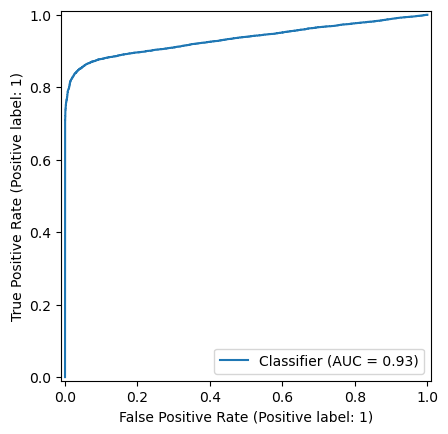

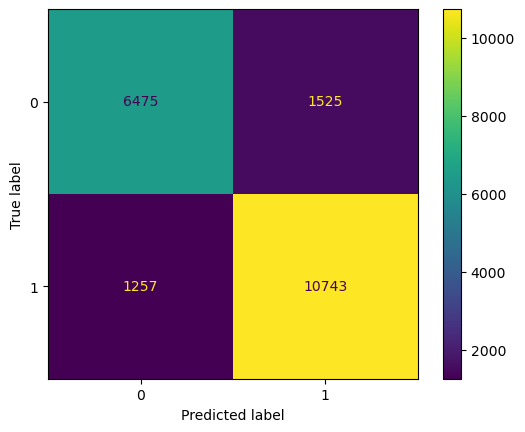

              precision    recall  f1-score   support

           0      0.837     0.809     0.823      8000
           1      0.876     0.895     0.885     12000

    accuracy                          0.861     20000
   macro avg      0.857     0.852     0.854     20000
weighted avg      0.860     0.861     0.860     20000



In [7]:
diag_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight=None
    ))
])

diag_model.fit(X_train_d, y_train_d)

# Probabilities + ROC AUC
proba_test = diag_model.predict_proba(X_test_d)[:, 1]
auc = roc_auc_score(y_test_d, proba_test)
print("ROC AUC:", round(auc, 4))

RocCurveDisplay.from_predictions(y_test_d, proba_test)
plt.show()

# Default threshold 0.5 -> confusion matrix + report
pred_test = (proba_test >= 0.5).astype(int)

cm = confusion_matrix(y_test_d, pred_test)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.show()

print(classification_report(y_test_d, pred_test, digits=3))


### Initial multiclass stage baseline (shows extreme imbalance issues for Type 1)

#### Stratified split for stage, excluding gestational rows

In [8]:
def is_gestational(x):
    if pd.isna(x):
        return False
    s = str(x).strip().lower()
    return "gest" in s  # catches "gestational", "gestational diabetes", etc.

mask_gest = df[STAGE_COL].apply(is_gestational)

df_stage = df.loc[~mask_gest].copy()
df_gest  = df.loc[mask_gest].copy()

X_stage = df_stage.drop(columns=drop_cols)
y_stage_ng = df_stage[STAGE_COL]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_stage, y_stage_ng,
    test_size=0.2,
    random_state=42,
    stratify=y_stage_ng
)

print("Non-gestational stage rows:", df_stage.shape[0])
print("Gestational rows (set aside):", df_gest.shape[0])
print("Stage distribution (test):")
print(y_test_s.value_counts(normalize=True).round(4))


Non-gestational stage rows: 99722
Gestational rows (set aside): 278
Stage distribution (test):
diabetes_stage
Type 2          0.5994
Pre-Diabetes    0.3193
No Diabetes     0.0800
Type 1          0.0013
Name: proportion, dtype: float64


### Logistic regression

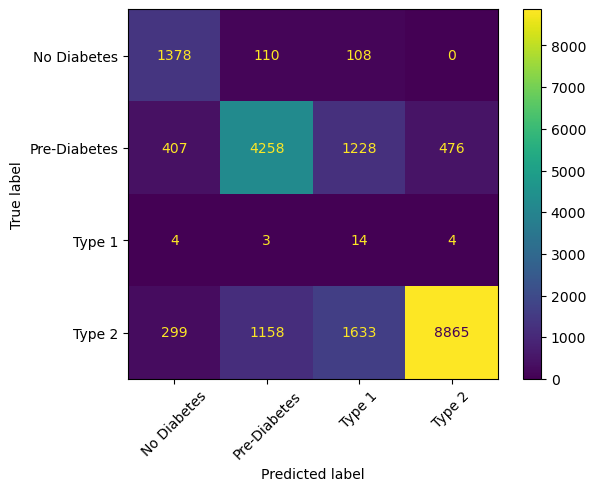

              precision    recall  f1-score   support

 No Diabetes      0.660     0.863     0.748      1596
Pre-Diabetes      0.770     0.669     0.716      6369
      Type 1      0.005     0.560     0.009        25
      Type 2      0.949     0.742     0.832     11955

    accuracy                          0.728     19945
   macro avg      0.596     0.708     0.576     19945
weighted avg      0.867     0.728     0.787     19945



In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

stage_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=5000,
        class_weight="balanced"   # Type 1 is very rare
    ))
])

stage_lr.fit(X_train_s, y_train_s)
pred_s = stage_lr.predict(X_test_s)

labels = ["No Diabetes", "Pre-Diabetes", "Type 1", "Type 2"]

ConfusionMatrixDisplay.from_predictions(
    y_test_s, pred_s, labels=labels, xticks_rotation=45, values_format="d"
)
plt.show()

print(classification_report(y_test_s, pred_s, labels=labels, digits=3))


### Random forest

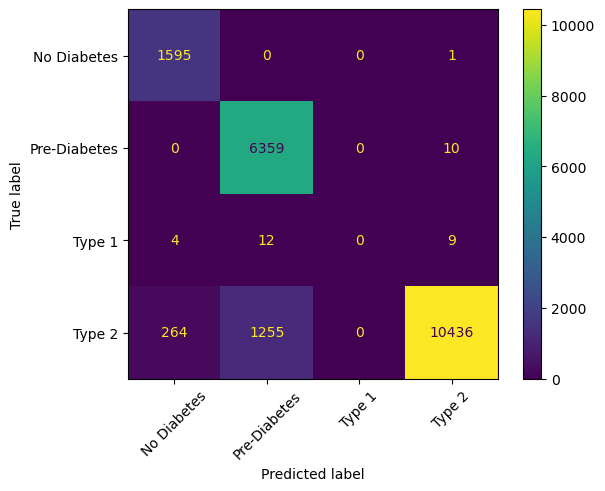

C:\Users\sofiaapr\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 No Diabetes      0.856     0.999     0.922      1596
Pre-Diabetes      0.834     0.998     0.909      6369
      Type 1      0.000     0.000     0.000        25
      Type 2      0.998     0.873     0.931     11955

    accuracy                          0.922     19945
   macro avg      0.672     0.718     0.691     19945
weighted avg      0.933     0.922     0.922     19945



C:\Users\sofiaapr\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sofiaapr\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
from sklearn.ensemble import RandomForestClassifier

stage_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

stage_rf.fit(X_train_s, y_train_s)
pred_rf = stage_rf.predict(X_test_s)

ConfusionMatrixDisplay.from_predictions(
    y_test_s, pred_rf, labels=labels, xticks_rotation=45, values_format="d"
)
plt.show()

print(classification_report(y_test_s, pred_rf, labels=labels, digits=3))


### Linear SVM (LinearSVC)

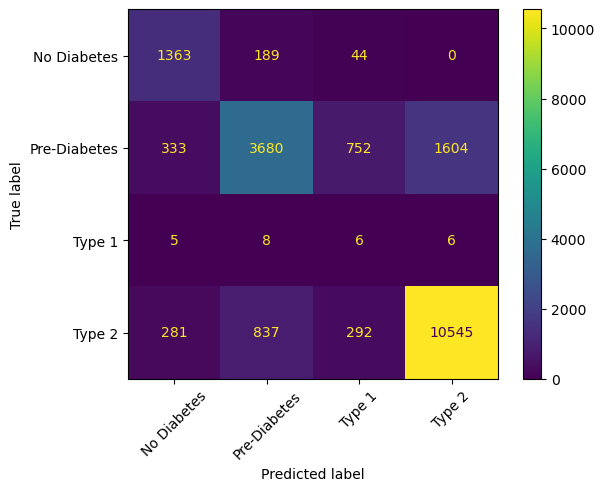

              precision    recall  f1-score   support

 No Diabetes      0.688     0.854     0.762      1596
Pre-Diabetes      0.781     0.578     0.664      6369
      Type 1      0.005     0.240     0.011        25
      Type 2      0.868     0.882     0.875     11955

    accuracy                          0.782     19945
   macro avg      0.585     0.638     0.578     19945
weighted avg      0.824     0.782     0.797     19945



In [11]:
from sklearn.svm import LinearSVC

stage_svm = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearSVC(class_weight="balanced", random_state=42))
])

stage_svm.fit(X_train_s, y_train_s)
pred_svm = stage_svm.predict(X_test_s)

ConfusionMatrixDisplay.from_predictions(
    y_test_s, pred_svm, labels=labels, xticks_rotation=45, values_format="d"
)
plt.show()

print(classification_report(y_test_s, pred_svm, labels=labels, digits=3))


#### Results

The initial 4-class diabetes stage baseline (No Diabetes / Pre-Diabetes / Type 1 / Type 2) reveals a severe class imbalance problem: Type 1 is extremely rare (only 25 samples in the test set after excluding gestational). As a result, different models either ignore Type 1 completely (no predicted samples, causing undefined precision/recall warnings) or over-predict Type 1, achieving higher recall but producing an unrealistic number of false positives.
Because this behaviour is driven by data scarcity rather than meaningful patterns, Type 1 is treated as out of scope for the main stage classifier in this academic project, and we focus on the clinically common and well-represented categories.

#### Refined scope

To obtain a stable and interpretable stage model, we restrict the non-gestational dataset to three classes: No Diabetes, Pre-Diabetes, and Type 2. Gestational diabetes is kept separate because it represents a distinct clinical context, and Type 1 is excluded from the main stage model due to very low prevalence and unreliable estimation in a standard multiclass setting.

#### Two views of the same model

Although a binary “diabetes vs no diabetes” task is closely related to stage classification, it serves a different purpose: binary classification is a screening problem (detect risk / avoid false negatives), while stage classification is a triage problem (distinguish Pre-Diabetes from Type 2 for downstream interpretation).

To avoid building redundant pipelines, we train a single 3-class model (No / Pre / Type 2) and evaluate it in two ways:
(1) Stage performance using multiclass metrics (confusion matrix, macro F1), and
(2) Binary screening performance by collapsing the predicted probabilities into P(diabetes)=1−P(No Diabetes), enabling ROC AUC and recall analysis.

### 3-class dataset (drop Type 1 and gestational)

In [14]:
STAGE_COL = "diabetes_stage"
DIAG_COL  = "diagnosed_diabetes"
LEAK_COL  = "diabetes_risk_score"

drop_cols = [c for c in [DIAG_COL, STAGE_COL, LEAK_COL] if c in df.columns]

def is_gestational(x):
    if pd.isna(x): 
        return False
    return "gest" in str(x).strip().lower()

mask_gest = df[STAGE_COL].apply(is_gestational)
df_ng = df.loc[~mask_gest].copy()

keep3 = ["No Diabetes", "Pre-Diabetes", "Type 2"]
df_3 = df_ng[df_ng[STAGE_COL].isin(keep3)].copy()

X3 = df_3.drop(columns=drop_cols)
y3 = df_3[STAGE_COL]

y3.value_counts()


diabetes_stage
Type 2          59774
Pre-Diabetes    31845
No Diabetes      7981
Name: count, dtype: int64

#### Train-test split

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42, stratify=y3
)

y_train.value_counts(normalize=True).round(4), y_test.value_counts(normalize=True).round(4)


(diabetes_stage
 Type 2          0.6001
 Pre-Diabetes    0.3197
 No Diabetes     0.0801
 Name: proportion, dtype: float64,
 diabetes_stage
 Type 2          0.6002
 Pre-Diabetes    0.3197
 No Diabetes     0.0801
 Name: proportion, dtype: float64)

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

len(num_cols), len(cat_cols)

(22, 6)

#### Logistic regression and random forest

C:\Users\sofiaapr\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Multinomial Logistic Regression (3-class): macroF1=0.835 | binary AUC=0.985


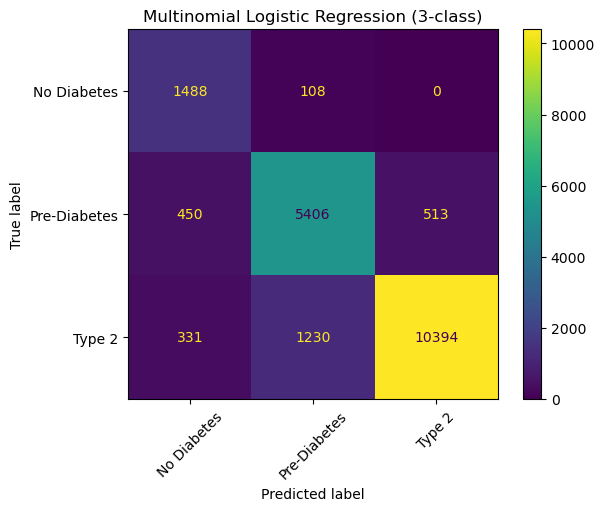

Random Forest (3-class): macroF1=0.919 | binary AUC=0.993


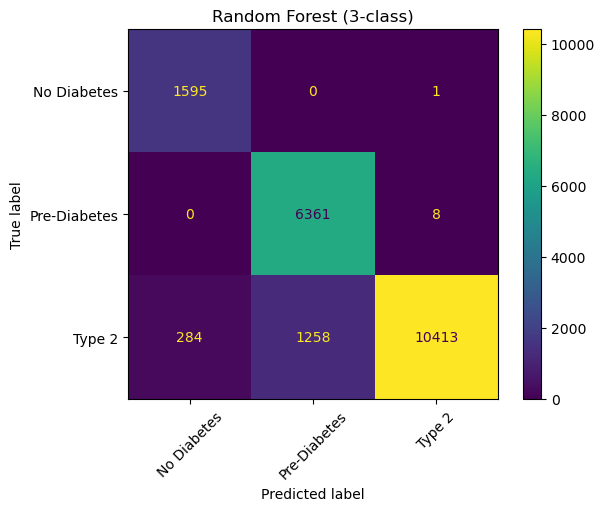

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels3 = ["No Diabetes", "Pre-Diabetes", "Type 2"]
idx_no = labels3.index("No Diabetes")

def eval_model(name, model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    macro_f1 = f1_score(y_test, pred, average="macro")

    proba = model.predict_proba(X_test)
    p_diabetes = 1 - proba[:, idx_no]
    y_bin = (y_test != "No Diabetes").astype(int)
    auc = roc_auc_score(y_bin, p_diabetes)

    print(f"{name}: macroF1={macro_f1:.3f} | binary AUC={auc:.3f}")

    ConfusionMatrixDisplay.from_predictions(
        y_test, pred, labels=labels3, xticks_rotation=45, values_format="d"
    )
    plt.title(name)
    plt.show()

lr3 = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=5000,
        multi_class="multinomial",
        class_weight="balanced"
    ))
])

rf3 = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

eval_model("Multinomial Logistic Regression (3-class)", lr3)
eval_model("Random Forest (3-class)", rf3)
